# Hashtag Grouping on Twitter

Input: 
    Hastag scrap result from cekmedsos_database.vw_ttidata

Output: 
    Mapping tables to group each hashtag entry with similarity
    

What we need to do....
1. Load the table entry from mySQL into python
2. Read the entry

Pre-requisite
pip install wheel
pip install pandas

### 1. Create Connection to mySQL

ref to this page:
    [How to Use Python with mySQL in Jupyter](https://medium.com/@tattwei46/how-to-use-python-with-mysql-79304bee8753)
    
first, we need to install mysql connector

In [1]:
import pymysql.cursors
import pandas as pd
import uuid

# --------------------------------------------------------------------------------
# This value is pass from API
# --------------------------------------------------------------------------------
# i_process_id = 1
# print(i_process_id)

### Get parameter from API Get

In [ ]:
# GET /cluster_analysis
req = json.loads(REQUEST)
args = req['args']

i_process_id = 0
i_process_id = args['process_id'][0]

### Input as proces started
Record header and parameter information

In [2]:
from datetime import datetime

# print(i_process_id)

# Connect to the database
connection = pymysql.connect(host='202.157.176.225',
                             user='cekmedsos_db',
                             password='kuku838485*#',
                             database='cekmedsos_database',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

#
# Query parameter of the jobs
sql = "select hastag, parameter from screen_analisis_ai where id = %s"
cursor.execute(sql, i_process_id)

result = cursor.fetchall()
database_keyword_id = result[0]['hastag']
similarity_treshold = result[0]['parameter']
screen_name = ''

#
# Create Header Record
sql = "insert into ret_analysis_header (job_id, datetime_start, user_id) values (%s, %s, %s)"
# Execute the query
# print(i_process_id)
cursor.execute(sql, (str(i_process_id), datetime.now(), 1 ))

#
# Create Parameter Record
sql = "insert into ret_analysis_parameter (job_id, param_id, param_name, param_value) values (%s, %s, %s, %s)"
# Execute the query
cursor.execute(sql, (i_process_id, 1, 'Similarity Treshold', similarity_treshold))
cursor.execute(sql, (i_process_id, 1, 'DB_ID', database_keyword_id))

# Commit Record
connection.commit()

1
1


#### Starting process, 
Run query against RDBMS


In [3]:
s_query_string = 'select id, tweet, tweet_date_time from ret_tweet where '

if (screen_name != ''):
    # print('use screen name')
    s_query_string = s_query_string + 'screen_name = "' + screen_name + '" and db_id = "' + str(database_keyword_id) + '"'
else:
    # print('no use')
    s_query_string = s_query_string + 'db_id = "' + str(database_keyword_id) + '"'
    
print(s_query_string)
df = pd.read_sql(s_query_string, con=connection)

# Close Connection
connection.close()

# see result
df.head()

select id, tweet, tweet_date_time from ret_tweet where db_id = "2907"


,id,tweet,tweet_date_time
0,1359291070861856768,"Orang-orang yang beriman dan beramal saleh, ba...",2021-02-10 07:00:20
1,1359291114608500737,Cuma islam yang serius membangun peradaban mas...,2021-02-10 07:00:30
2,1359291133088518146,"An Ottoman Officer, 1898 Bir Osmanlı Subayı, ...",2021-02-10 07:00:35
3,1359291332703920128,Barangsiapa membaca satu huruf dari Al Qur'an ...,2021-02-10 07:01:22
4,1359291390425853953,"Barangsiapa akhir ucapannya ""Laa ilaaha illall...",2021-02-10 07:01:36


### 2. Try to pre-process all the text

target-> tokenizing into another dataframe

In [4]:
import string
import re
import nltk

from nltk.tokenize import word_tokenize

# Text Preprocessing, 
def text_preproc(strIn):
    # case folding
    strOut = strIn.lower()
    # remove numbers
    strOut = re.sub(r"\d+", "", strOut)
    # remote punctuation
    strOut = strOut.translate(str.maketrans("","",string.punctuation))
    # remove whitspace
    strOut = strOut.strip()
    # 
    strOut = re.sub('\s+',' ',strOut)
    
    return strOut
# end Text Preprocessing


# Apply to data frame
df['tweet'] = df['tweet'].apply(text_preproc)

# df.head()

,id,tweet,tweet_date_time
0,1359291070861856768,orangorang yang beriman dan beramal saleh bagi...,2021-02-10 07:00:20
1,1359291114608500737,cuma islam yang serius membangun peradaban mas...,2021-02-10 07:00:30
2,1359291133088518146,an ottoman officer bir osmanlı subayı islamsel...,2021-02-10 07:00:35
3,1359291332703920128,barangsiapa membaca satu huruf dari al quran m...,2021-02-10 07:01:22
4,1359291390425853953,barangsiapa akhir ucapannya laa ilaaha illalla...,2021-02-10 07:01:36


### Finish preprocessing, Tokenized
Next step, is to output to new column for tokenized sentence

In [5]:
from nltk.corpus import stopwords 

# Load stopwords
sw = stopwords.words('indonesian')

# apply tokenize
df['tokenized_tweet'] = df.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)
# apply stopword removal
df['sw'] = df.apply(lambda row: {w for w in row['tokenized_tweet'] if not w in sw}, axis=1)

# print((df))

### Define function to calculate similarity
Function return similarity score

In [6]:
def calculate_similarity(X_set, Y_set):
# Program to measure the similarity between  
# two sentences using cosine similarity. 

    l1 =[];l2 =[]

    # form a set containing keywords of both strings  
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0) 
        if w in Y_set: l2.append(1) 
        else: l2.append(0) 
    c = 0

    # cosine formula  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    
    return cosine

def largest_in_col(arr,nCol):
    # 
    # Find largest value of col nCol on 2D arr
    #
    
    # init value
    max_val = arr[0][nCol]
    # also, remember index
    row_index = 0
    
    for x in range(0, len(arr)):
        if arr[x][nCol] > max_val:
            max_val = arr[x][nCol]
            row_index = x
        
    return max_val,row_index


### Try to using function
using some of array cells, create n matrices

1. take one tweet, compare to all data set
2. flag 1 if similar
3. take next tweet, if similar from prev tweet, skip
4. if not similar, add counter, then proceed

In [7]:
import numpy as np
import array as arr
import multitasking
from tqdm import tqdm

# set to max CPU Cores
# multitasking.set_max_threads(multitasking.config["CPU_CORES"] * 5)

st = similarity_treshold
cluster_no = 1
s_score = 0
s_score_current = 0
i_current_cluster = 0

#create zero element array
#col 0 => index base tweet
#col 1 => cluster number
#col 2 => similarity score
base_tweet = []

#proceed to compare to all tweet
cosine_matrix = np.zeros(( len(df), len(df) ))

# flag the mt
with tqdm(total=( (len(df)*len(df)/2))-(len(df)/2))  as pbar:
    for j in range(0, len(df)):
        tweet_to_compare = df['sw'][j]

        #check, is this second tweet?
        if(j == 0):
            #first tweet, add as cluster no #1
            base_tweet.append([j,1,1.0])
            i_current_cluster = base_tweet[0][1]

        elif(j == 1):
            #compare to prev tweet
            s_score = calculate_similarity(tweet_to_compare, df['sw'][ base_tweet[0][0] ])

            if(s_score < st):
                #not similar
                base_tweet.append([j,2,1])
                i_current_cluster = base_tweet[j][1]

        else:
            #other else tweet
            for x in range(0,len(base_tweet)):
                #compare every element
                s_score = calculate_similarity(tweet_to_compare, df['sw'][ base_tweet[x][0] ])
                base_tweet[x][2] = s_score

            if(largest_in_col(base_tweet,2)[0] < st):
                #no similar, add as one new cluster
                i_current_cluster = i_current_cluster + 1
                base_tweet.append([j,i_current_cluster,largest_in_col(base_tweet,2)[0]])
            else:
                #determine cluster# from biggest similarity
                i_current_cluster = base_tweet[(largest_in_col(base_tweet,2)[1])][1]

        #proceed to compare to all tweet
        for i in range(0,len(df)):
            # update progress
            if (j<i):
                pbar.update(1)
                s_score = calculate_similarity(tweet_to_compare, df['sw'][i])
                if (s_score >= st):
                    cosine_matrix[i,j] = i_current_cluster

        
pbar.close()
print(cosine_matrix)

100%|██████████| 5460/5460.0 [00:00<00:00, 21405.97it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<AxesSubplot:>

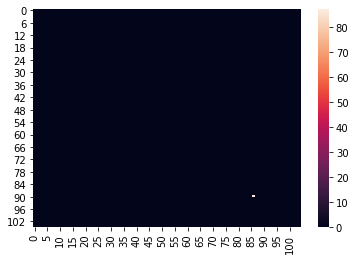

In [8]:
import seaborn as sns

sns.heatmap(cosine_matrix)


### Writing result to file
Using NPZ format for efficiency, and try to load them after save


In [9]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

# save to npy file
savez_compressed('./output/df_380.npz',df)
savez_compressed('./output/data_380.npz', cosine_matrix)
savez_compressed('./output/data_380_base.npz', base_tweet)

print(len(cosine_matrix))
print('Save data complete .... ')

105
Save data complete .... 


### How to save to rdbms?
save the header data, meta data of the process
[ret_analysis_header]
- JobID
- user initiated
- Time Started
- Time End

Process Parameter
[ret_analysis_parameter]
- JobID
- Param Name
- Param Value
    - ST Value
    - DB ID
    - Screen Name
    - How Many Tweet analyzed

save detail cluster information
[ret_base_tweet]
- JobID
- Tweet Base# --> tweet ID
- Cluster#

save detail calculation result, structure
[ret_cluster_result]
- JobID
- TweetID
- Cluster

In [10]:
# Connect to the database
connection = pymysql.connect(host='202.157.176.225',
                             user='cekmedsos_db',
                             password='kuku838485*#',
                             database='cekmedsos_database',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

#
# Create Base Tweet Record
sql = "insert into ret_base_tweet (job_id, tweet_id, cluster_id) values (%s, %s, %s)"

## inserting base tweet
for i in range(0,len(base_tweet)):
    # Execute the query
    cursor.execute(sql, (i_process_id, df['id'][i], base_tweet[i][1]))
    
connection.commit()
connection.close()

print('finished inserting base tweet record')

finished inserting base tweet record


### Record cluster result
into table ret_cluster_result

In [11]:
# Connect to the database
connection = pymysql.connect(host='202.157.176.225',
                             user='cekmedsos_db',
                             password='kuku838485*#',
                             database='cekmedsos_database',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

#
# Create Tweet Cluster Record
sql = "insert into ret_cluster_result (job_id, tweet_id, cluster_no) values (%s, %s, %s)"

print(len(cosine_matrix))
print(i_process_id)

# initiate cluster number
i_cluster_no_save = 0
temp_val = 0
                 
## inserting tweet cluster
for i in range(0, len(cosine_matrix)):
    
    # find value in this particular row
    for j in range(0,len(cosine_matrix[i])):
        
        # print(cosine_matrix[i][j])
        temp_val = cosine_matrix[i][j]
        
        if(temp_val != 0):
            i_cluster_no_save = temp_val

    # Execute the query
    cursor.execute(sql, (i_process_id, df['id'][i], i_cluster_no_save))
    
connection.commit()
connection.close()

print('finished inserting cluster data')

105
1
finished inserting cluster data


### Record finish time
update table ret_analysis_header

In [12]:
# Connect to the database
connection = pymysql.connect(host='202.157.176.225',
                             user='cekmedsos_db',
                             password='kuku838485*#',
                             database='cekmedsos_database',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

#
# Create Parameter Record
sql = "insert into ret_analysis_parameter (job_id, param_id, param_name, param_value) values (%s, %s, %s, %s)"
# Execute the query
cursor.execute(sql, (i_process_id, 1, '#Tweet Processed',len(df)))

#
# Create Tweet Cluster Record
sql = "update ret_analysis_header set datetime_finish = %s where job_id = %s"
# Executing query
cursor.execute(sql, (datetime.now(),i_process_id) )

print(i_process_id)

connection.commit()
connection.close()

print('job finished')

1
job finished


### Next thing todo list ...
1. Create data structure to record below things
    Job Header
    - JobID
    - Similarity Treshold
    - Dataset Parameter
        - By User
        - By Keyword
    - Running time start
    - Running time end
    
    Dataset Result
        - base_tweet
        - cosine_matrix
        
2. Push the result data into RDBMS Server, in this case is mySQL
    - upload csv file to mySQL
    - import to database